# Exerscise 2-2

이 연습에서는 정규화를 추가하여 로지스틱 회귀 알고리즘을 개선합니다. 정규화는 알고리즘이 "더 단순한" 모델을 선호하게 만드는 비용 함수의 용어입니다 (이 경우 모델은 더 작은 z크기의 계수). 이론은 과적응(overfitting)을 최소화하고 모델의 일반화 능력을 향상시키는 데 도움이 된다는 것입니다.

제조 공장의 마이크로 칩이 품질 보증(QA)을 통과하는지 여부를 예측하기 위해 정규화 된 로지스틱 회귀 분석을 구현합니다. 품질 보증 기간 동안 각 마이크로 칩은 올바르게 작동하는지 확인하기 위해 다양한 테스트를 거칩니다.
당신은 공장의 제품 관리자이고, 두 가지 테스트에서 일부 마이크로 칩에 대한 테스트 결과가 있다고 가정 해보십시오. 이 두 가지 검사에서 마이크로 칩을 허용할지 아니면 거절할지를 결정하고 싶습니다. 의사 결정을 돕기 위해 과거의 마이크로 칩에 대한 테스트 결과의 데이터 세트가 있으며, 이로부터 로지스틱 회귀 모델을 구축 할 수 있습니다.
먼저 필요한 라이브러리를 로드해 봅시다.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt    # more on this later

다음은 자료를 읽어옵니다.

In [16]:
data = pd.read_csv('ex2data2.txt', header = None)
# or data = pd.read_csv(path, header=None, names=['test1','test2','accepted'])
X = data.iloc[:,:2]
y = data.iloc[:,2]
data.head()

,0,1,2
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


그래서 우리는 두 개의 독립적인 특징과 하나의 결과값을 가지고 있습니다. 여기서 0은 칩이 거부됨, 1 은 받아 들여짐을 의미합니다.

## 데이터 시각화

학습 알고리즘을 구현하기 전에 가능한 경우 데이터를 시각화하는 것이 좋습니다.

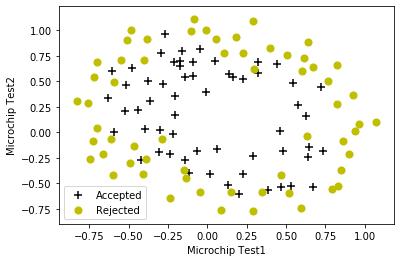

In [4]:
mask = y == 1  # y == 1 인 요소들에 true 할당
passed = plt.scatter(X[mask][0].values, X[mask][1].values, s=50, c='k', marker='+',)
failed = plt.scatter(X[~mask][0].values, X[~mask][1].values, s=50, c='y', marker='o',)
plt.xlabel('Microchip Test1')
plt.ylabel('Microchip Test2')
plt.legend((passed, failed), ('Accepted', 'Rejected'))
plt.show()

위의 그림은 우리의 데이터 세트가 직선으로 양수 및 음수 결과로 분리 될 수 없음을 플롯을 통해 보여줍니다. 따라서 로지스틱 회귀의 직선적인 적용은 선형 결정 경계 만 찾을 수 있기 때문에 이 데이터 세트에서 잘 수행되지 않습니다. 로지스틱 회귀와 같은 선형 기법을 사용하여 이를 처리하는 한 가지 방법은 원래 특징들의 다항식에서 파생된 특징들을 생성하는 것 입니다. 먼저 다항식 특징을 만들어 봅시다.


## 특징 매핑

데이터를 더 잘 맞추는 한 가지 방법은 각 데이터 요소에서 더 많은 특징을 만드는 것입니다. 그러므로 우리는 모든 다항식 항 $x_1$ 과 $x_2$의 6차 항까지의 특징들로 맵핑 할 것 입니다.

<img width="300" src="https://cdn-images-1.medium.com/max/800/1*-n0H6dB-gVYUXg3nGvTAgw.png">

이 매핑의 결과로 두 개의 특징(두 가지 QA 테스트의 점수)벡터가 28차원 벡터로 변형되었습니다. 이 고차원 특성 벡터에 대해 학습된 로지스틱 회귀 분류자는 보다 복잡한 결정 경계를 가지며 2 차원 플롯에서 그릴 때 비선형으로 나타납니다.

특징 매핑을 사용하면 뛰어난 분류 기준을 만들 수는 있지만, 동시에 과적합될 수도 있습니다. 연습의 다음 부분에서는 데이터에 맞게 정규화 된 로지스틱 회귀 분석을 구현하고 정규화가 과도한 문제를 해결하는 방법을 직접 확인합니다.

In [5]:
def mapFeature(X1, X2, degree):
    out = np.ones(X.shape[0])[:,np.newaxis]
    for i in range(1, degree+1):
        for j in range(i+1):
            out = np.hstack((out, np.multiply(np.power(X1, i-j),                                     np.power(X2, j))[:,np.newaxis]))
    return out
degree = 6
X = mapFeature(X.iloc[:,0], X.iloc[:,1], degree)
X[0,:]

array([1.00000000e+00, 5.12670000e-02, 6.99560000e-01, 2.62830529e-03,
       3.58643425e-02, 4.89384194e-01, 1.34745327e-04, 1.83865725e-03,
       2.50892595e-02, 3.42353606e-01, 6.90798869e-06, 9.42624411e-05,
       1.28625106e-03, 1.75514423e-02, 2.39496889e-01, 3.54151856e-07,
       4.83255257e-06, 6.59422333e-05, 8.99809795e-04, 1.22782870e-02,
       1.67542444e-01, 1.81563032e-08, 2.47750473e-07, 3.38066048e-06,
       4.61305487e-05, 6.29470940e-04, 8.58939846e-03, 1.17205992e-01])

## 구현

실제 비용 함수로 시작하기 전에 로지스틱 회귀 가설은 시그모이드 함수를 사용한다는 것을 상기하십시오. 시그모이드 함수를 정의합시다.


## Sigmoid Function

In [6]:
def sigmoid (x) : 
  return 1 / (1 + np.exp (-x))

## 비용 함수

평소처럼 우리의 비용 함수와 그레디언트 함수를 코드화 할 수 있습니다.

<img width="500" src="https://cdn-images-1.medium.com/max/800/1*CQpFY41vGbjxIM0-rYqeSw.png">


In [7]:
#
# Hint :  X * theta ==> np.matmul(X, theta)  or X @ theta
#         Sum(y_i * log(hx)_i) ==> np.matmul(y.T, np.log(hx))  or y.T @ np.log(hx)
#
def lrCostFunction(theta, X, y, lmbda):
    # problem-1 (10) =================
    m = len(y)
    #J = (-1/m) * (y.T @ np.log(sigmoid(X @ theta)) + (1 - y.T) @ np.log(1 - sigmoid(X @ theta)))
    #reg = (lmbda/(2*m)) * (theta[1:].T @ theta[1:])
    #J = J + reg
    hx = np.matmul(X, theta)
    J = (-1/m) * np.matmul(y.T, np.log(sigmoid(hx)))
    J = J + (-1/m) * np.matmul((1-y.T),np.log(1-sigmoid(hx)))
    J = J + (lmbda/(2*m)) * np.matmul(theta[1:].T, theta[1:])
    #===============================
    return J

비용 함수를 코딩하는 여러 가지 방법이 있습니다. 무엇보다 중요한 것은 수학의 기본 아이디어와 코드로 변환 할 수 있는 능력입니다.

## 그라디언트 함수

비용 함수의 기울기는 j 번째 요소가 다음과 같이 정의되는 벡터입니다.
$$ {\partial J (\theta) \over \partial \theta_0 } = {1\over m }\sum_{i=1}^m (h_\theta (x^{(i)}) - y^{(i)})x_j^{(i)}    \quad \textrm{for} \quad j=0 $$
$$ {\partial J (\theta) \over \partial \theta_0 } = {1\over m }\sum_{i=1}^m (h_\theta (x^{(i)}) - y^{(i)})x_j^{(i)}    + {\lambda \over m} \theta_j \quad \textrm{for} \quad j\ge 0 $$


방정식에서 "lmbda"용어를 주목하십시오. 또한 "학습 속도"매개 변수 추가에 유의하십시오. 이것은 정규화 용어의 효과를 제어하는 하이퍼 매개 변수입니다. 이제 그라디언트 함수에 정규화를 추가해야 합니다.

In [8]:
def lrGradientDescent(theta, X, y, lmbda):
    # Problrm-2 (10) ========================
    m = len(y)
    #grad = np.zeros([m,1])
    #grad = (1/m) * X.T @ (sigmoid(X @ theta) - y)
    hx = np.matmul(X,theta)
    grad = (1/m) * np.matmul(X.T, (sigmoid(hx) - y))
    grad[1:] = grad[1:] + (lmbda / m) * theta[1:]
    # ======================================
    return grad

초기 매개 변수를 사용하여 이 함수를 호출 해 봅시다.

In [9]:
(m, n) = X.shape
y = y[:, np.newaxis]
theta = np.zeros((n,1))
lmbda = 1.
J = lrCostFunction(theta, X, y, lmbda)
print(J)

[[0.69314718]]


이것은 우리에게 값 0.69314718를 줍니다

## fmin_tnc를 사용한 매개 변수 학습

이전 게시물과 유사하게 우리는 **fmin_tnc**를 사용합니다.

**fmin_tnc**는 제약되지 않은 함수의 최소값을 찾는 최적화 솔버입니다. 로지스틱 회귀 분석에서는 매개 변수 theta 로 비용 함수를 최적화하려고 합니다 

In [10]:
output = opt.fmin_tnc(func = lrCostFunction, x0 = theta.flatten(), fprime = lrGradientDescent, \
                         args = (X, y.flatten(), lmbda))
theta = output[0]
print(theta) # theta contains the optimized values

[ 1.27271026  0.62529965  1.18111687 -2.019874   -0.91743189 -1.4316693
  0.12393227 -0.36553118 -0.35725406 -0.17516292 -1.45817009 -0.05098418
 -0.61558555 -0.27469165 -1.19271297 -0.2421784  -0.20603301 -0.04466178
 -0.27778948 -0.29539513 -0.45645982 -1.04319154  0.02779373 -0.29244867
  0.01555759 -0.32742404 -0.1438915  -0.92467487]


flatten()함수에 대한 참고 사항 : 불행히도 scipy’s fmin_tnc 는 열이나 행 벡터에서는 잘 작동하지 않습니다. 매개 변수가 배열 형식이어야합니다. 이 flatten()함수는 열 또는 행 벡터를 배열 형식으로 줄입니다.

### 모델의 정확도

학습된 매개 변수의 결과를 예측하고 원래 결과와 비교하여 모형 정확도를 찾으십시오.

In [11]:
pred = [sigmoid(np.dot(X, theta)) >= 0.5]
np.mean(pred == y.flatten()) * 100

83.05084745762711

이것은 모델 정확도 83.05% 를 제공합니다 .

## 결정 경계선 그리기

이 분류 기준에서 학습 한 모델을 시각화 할 수 있도록 양수 및 음수 예제를 구분하는 (비선형) 결정 경계를 그립니다. 우리는 균등하게 간격을 둔 그리드에서 분류자의 예측을 계산하여 비선형 결정 경계를 도출한 다음, y = 0 에서 y = 1로 예측이 바뀌는 등고선도를 그립니다.

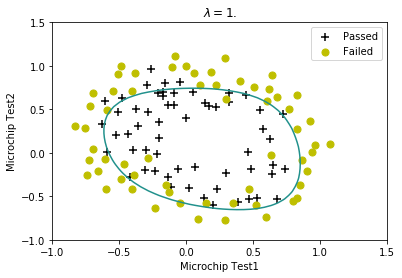

In [12]:
u = np.linspace(-1, 1.5, 50)
v = np.linspace(-1, 1.5, 50)
z = np.zeros((len(u), len(v)))

def mapFeatureForPlotting(X1, X2, degree):
    out = np.ones(1)
    for i in range(1, degree+1):
        for j in range(i+1):
            out = np.hstack((out, np.multiply(np.power(X1, i-j), np.power(X2, j))))
    return out

for i in range(len(u)):
    for j in range(len(v)):
        z[i,j] = np.dot(mapFeatureForPlotting(u[i], v[j], degree), theta)
        
mask = y.flatten() == 1
X = data.iloc[:,:-1]
passed = plt.scatter(X[mask][0].values, X[mask][1].values, s=50, c='k', marker='+',)
failed = plt.scatter(X[~mask][0].values, X[~mask][1].values, s=50, c='y', marker='o',)
plt.contour(u,v,z,0)
plt.xlabel('Microchip Test1')
plt.ylabel('Microchip Test2')
plt.title('$\lambda = 1$.')
plt.legend((passed, failed), ('Passed', 'Failed'))
plt.show()

우리의 모델은 다양한 데이터 포인트를 분류하는 데 매우 효과적입니다.

Problem-3 (6 points) lambda 값을 0, 0.01, 3 과 같은 3가지 값으로 변경하여, 결정 경계가 어떻게 변경되는지 직접 확인하십시오.


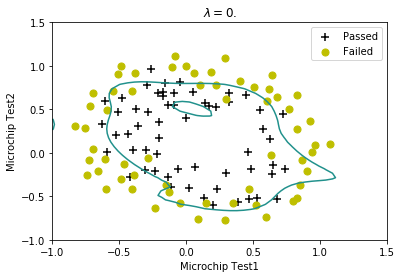

In [13]:
# Problem-3 (6)
degree = 6
X = mapFeature(X.iloc[:,0], X.iloc[:,1], degree)
theta = np.zeros((n,1))
lmbda = 0.
output = opt.fmin_tnc(func = lrCostFunction, x0 = theta.flatten(), fprime = lrGradientDescent, \
                         args = (X, y.flatten(), lmbda))
theta = output[0]

for i in range(len(u)):
    for j in range(len(v)):
        z[i,j] = np.dot(mapFeatureForPlotting(u[i], v[j], degree), theta)
        
mask = y.flatten() == 1
X = data.iloc[:,:-1]
passed = plt.scatter(X[mask][0].values, X[mask][1].values, s=50, c='k', marker='+',)
failed = plt.scatter(X[~mask][0].values, X[~mask][1].values, s=50, c='y', marker='o',)
plt.contour(u,v,z,0)
plt.xlabel('Microchip Test1')
plt.ylabel('Microchip Test2')
plt.title('$\lambda = 0$.')
plt.legend((passed, failed), ('Passed', 'Failed'))
plt.show()

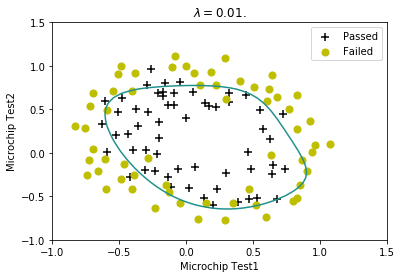

In [14]:
degree = 6
X = mapFeature(X.iloc[:,0], X.iloc[:,1], degree)
theta = np.zeros((n,1))
lmbda = 0.01
output = opt.fmin_tnc(func = lrCostFunction, x0 = theta.flatten(), fprime = lrGradientDescent, \
                         args = (X, y.flatten(), lmbda))
theta = output[0]

for i in range(len(u)):
    for j in range(len(v)):
        z[i,j] = np.dot(mapFeatureForPlotting(u[i], v[j], degree), theta)
        
mask = y.flatten() == 1
X = data.iloc[:,:-1]
passed = plt.scatter(X[mask][0].values, X[mask][1].values, s=50, c='k', marker='+',)
failed = plt.scatter(X[~mask][0].values, X[~mask][1].values, s=50, c='y', marker='o',)
plt.contour(u,v,z,0)
plt.xlabel('Microchip Test1')
plt.ylabel('Microchip Test2')
plt.title('$\lambda = 0.01$.')
plt.legend((passed, failed), ('Passed', 'Failed'))
plt.show()

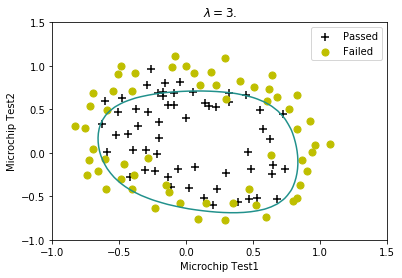

In [15]:
degree = 6
X = mapFeature(X.iloc[:,0], X.iloc[:,1], degree)
theta = np.zeros((n,1))
lmbda = 3.
output = opt.fmin_tnc(func = lrCostFunction, x0 = theta.flatten(), fprime = lrGradientDescent, \
                         args = (X, y.flatten(), lmbda))
theta = output[0]

for i in range(len(u)):
    for j in range(len(v)):
        z[i,j] = np.dot(mapFeatureForPlotting(u[i], v[j], degree), theta)
        
mask = y.flatten() == 1
X = data.iloc[:,:-1]
passed = plt.scatter(X[mask][0].values, X[mask][1].values, s=50, c='k', marker='+',)
failed = plt.scatter(X[~mask][0].values, X[~mask][1].values, s=50, c='y', marker='o',)
plt.contour(u,v,z,0)
plt.xlabel('Microchip Test1')
plt.ylabel('Microchip Test2')
plt.title('$\lambda = 3$.')
plt.legend((passed, failed), ('Passed', 'Failed'))
plt.show()